# Cohort of interest

In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2
# black formatter for jupyter notebooks
#%load_ext nb_black
# black formatter for jupyter lab
%load_ext lab_black

%run ../src/notebook_env.py


---------------------------------
Working on the host: Joachims-MacBook-Pro.local

---------------------------------
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]

---------------------------------
Python interpreter: /opt/miniconda3/envs/idz-parostatus/bin/python

---------------------------------
Root (ROOT) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus
---------------------------------
data (DATA) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/data
---------------------------------
Attaching the following source folders:
/Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/src


**Import modules**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re

## Load spss dataset

In [3]:
fp = DATA.joinpath("raw", "DMSV_FM", "data", "derived")
fn = "3c_DMSV_FM.sav"
file = fp.joinpath(fn)
assert file.exists()

In [4]:
raw = pd.read_spss(file)
raw = raw.set_index("id")

In [5]:
# raw.describe()

In [6]:
raw.shape[0]

1332

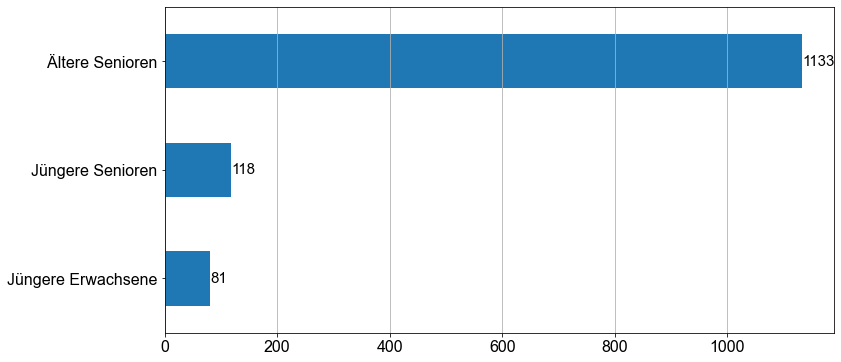

In [7]:
ax = raw.groupby("altgr")["altgr"].count().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.set_ylabel("")
ax.grid(axis="x")

## Exclusion criteria
* Edentulous participants
* Maximum PD and maximum interdental CAL are missing
* BOP is missing
* the number of missing teeth (due to periodontitis) is missing

### Edentulous participants

In [8]:
(raw["zahnzahl"] == 0).sum()

352

In [9]:
data = raw.loc[raw.zahnzahl != 0].copy()
data.shape[0]

980

### Maximum PD and maximum interdental CAL are missing

#### PD measurements missing

In [10]:
pattern_ppd = r"st\d{2}\w{4}$"
# bool(re.match(pattern_ppd, "st11odis"))
cols = data.columns[[bool(re.match(pattern_ppd, c)) for c in data.columns]]
data[cols].isnull().all(axis=1).sum()

0

#### Interdental CAL measurements missing 

In [11]:
missing_cal = data["maxCALappr"].isnull().sum()
missing_cal

122

In [12]:
assert missing_cal == (data["zahnzahl"] == data["kronenzahl"]).sum()

> Recessions were not recorded in DMS V on crowned teeth, PD was though recorded

##### --> Considered as Special Case "No CAL measurements" 

In [13]:
# uncomment to exclude
# data = data.loc[data["maxCALappr"].notnull()].copy()
# data.shape[0]

### BOP is missing

Recorded at tooth level, not at tooth surface level as intended in classification

In [14]:
data["bop"].isnull().sum()

0

### The number of missing teeth (due to periodontitis) is missing

Staging is modified by the number of missing teeth attributed to periodontitis. If information about tooth loss due to periodontitis is not available classification into stage IV is primarily related to the number of occluding pairs (<10 occluding pairs).

## Cohort of intersest

980


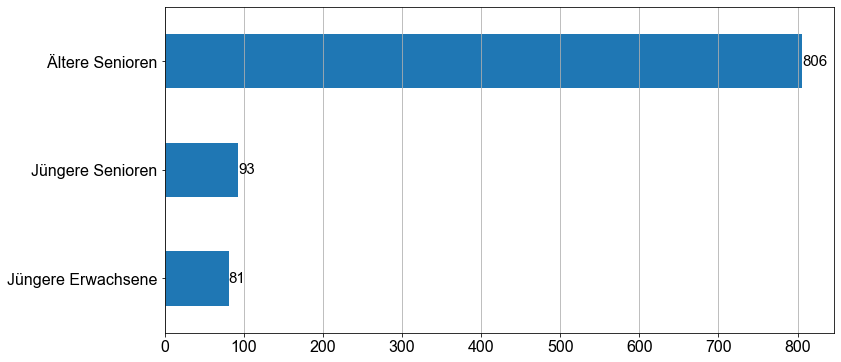

In [15]:
ax = data.groupby("altgr")["altgr"].count().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.set_ylabel("")
ax.grid(axis="x")
print(data.shape[0])

### Save to disk


In [16]:
fn = "dmsV_cohort.parquet"
fp = DATA.joinpath("processed", fn)
data.to_parquet(fp)
assert fp.exists(), fp